## Clarifying the cause of tensor exceptions

In [1]:
! pip install -q tensor-sensor
! pip install -q -U graphviz

### NumPy

In [2]:
%load_ext autoreload
import tsensor
import numpy as np
import sys

W = np.array([[1, 2], [3, 4]])
b = np.array([9, 10]).reshape(2, 1)
x = np.array([4, 5]).reshape(2, 1)
h = np.array([1,2])

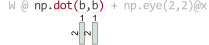

PyTorch says: shapes (2,1) and (2,1) not aligned: 1 (dim 1) != 2 (dim 0)

tsensor adds: Cause: np.dot(b,b) tensor arg b w/shape (2, 1), arg b w/shape (2, 1)


In [3]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
        W @ np.dot(b,b) + np.eye(2,2)@x
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

### PyTorch

In [4]:
import tsensor
import torch
import sys

W = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([9, 10]).reshape(2, 1)
x = torch.tensor([4, 5]).reshape(2, 1)
h = torch.tensor([1,2])

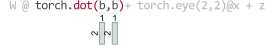

PyTorch says: 1D tensors expected, got 2D, 2D tensors at /tmp/pip-req-build-as628lz5/aten/src/TH/generic/THTensorEvenMoreMath.cpp:83

tsensor adds: Cause: torch.dot(b,b) tensor arg b w/shape [2, 1], arg b w/shape [2, 1]


In [5]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
        W @ torch.dot(b,b)+ torch.eye(2,2)@x + z
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

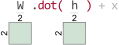

PyTorch says: 1D tensors expected, got 2D, 1D tensors at /tmp/pip-req-build-as628lz5/aten/src/TH/generic/THTensorEvenMoreMath.cpp:83

tsensor adds: Cause: W.dot(h) tensor arg h w/shape [2]


In [6]:
try:
    with tsensor.clarify():
        W.dot(h) + x
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

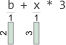

tensorflow says: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0

tsensor adds: Cause: + on tensor operand b w/shape [2, 1] and operand x*3 w/shape [3, 1]


In [7]:
x = torch.tensor([4, 5, 6]).reshape(3, 1)

try:
    with tsensor.clarify():
        b + x * 3
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("tensorflow says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

### TensorFlow

In [8]:
import tensorflow as tf

In [9]:
W = tf.constant([[1, 2], [3, 4]])
b = tf.reshape(tf.constant([[9, 10]]), (2, 1))
x = tf.reshape(tf.constant([[8, 5, 7]]), (3, 1))

In [10]:
res = tf.matmul(W, b)

In [11]:
W @ b

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[29],
       [67]], dtype=int32)>

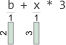

tensorflow says: Incompatible shapes: [2,1] vs. [3,1] [Op:AddV2]

tsensor adds: Cause: + on tensor operand b w/shape (2, 1) and operand x*3 w/shape (3, 1)


In [12]:
try:
    with tsensor.clarify():
        x * 3
        b + x * 3
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("tensorflow says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

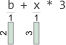

tensorflow says: Incompatible shapes: [2,1] vs. [3,1] [Op:AddV2]

tsensor adds: Cause: + on tensor operand b w/shape (2, 1) and operand x*3 w/shape (3, 1)


In [13]:
def foo(): bar()
def bar():
    b + x * 3

try:
    with tsensor.clarify(): # works for any called functions too
        foo()
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("tensorflow says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

## Explaining matrix algebra statements visually

In [14]:
W = torch.rand(size=(2000,2000))
b = torch.rand(size=(2000,1))
h = torch.rand(size=(1_000_000,))
x = torch.rand(size=(2000,1))

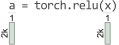

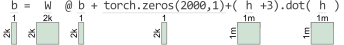

In [15]:
import tsensor
with tsensor.explain() as explained:
    a = torch.relu(x)
    b = W @ b + torch.zeros(2000,1)+(h+3).dot(h)

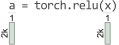

In [16]:
explained.views[0]

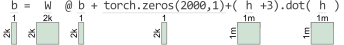

In [17]:
explained.views[1]

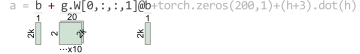

torch says: The size of tensor a (2000) must match the size of tensor b (20) at non-singleton dimension 0

torch adds: Cause: + on tensor operand b w/shape [2000, 1] and operand g.W[0,:,:,1]@b w/shape [20, 1]


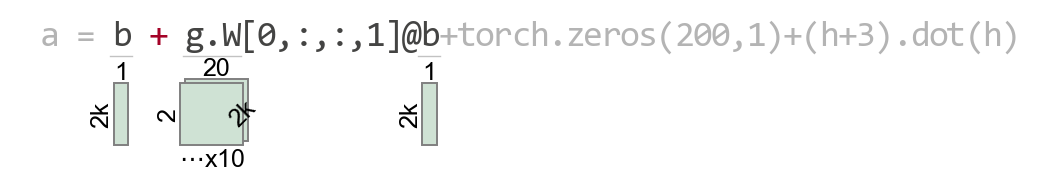

In [18]:
class GRU: # fake random junk
    def __init__(self):
        self.W = torch.rand(size=(2,20,2000,10))
        self.b = torch.rand(size=(20,1))

# W = torch.tensor([[1, 2], [3, 4]])
b = torch.rand(size=(2000,1))
h = torch.rand(size=(1_000_000,2))

g = GRU()
try:
    with tsensor.explain():
        a = b + g.W[0,:,:,1]@b+torch.zeros(200,1)+(h+3).dot(h)
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("torch says: "+msgs[0]+'\n\n')
    sys.stderr.write("torch adds: "+msgs[1]+'\n')

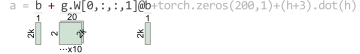

torch says: The size of tensor a (2000) must match the size of tensor b (20) at non-singleton dimension 0

torch adds: Cause: + on tensor operand b w/shape [2000, 1] and operand g.W[0,:,:,1]@b w/shape [20, 1]


In [19]:
try:
    with tsensor.clarify():
        a = b + g.W[0,:,:,1]@b+torch.zeros(200,1)+(h+3).dot(h)
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("torch says: "+msgs[0]+'\n\n')
    sys.stderr.write("torch adds: "+msgs[1]+'\n')

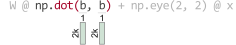

torch says: shapes (2000,1) and (2000,1) not aligned: 1 (dim 1) != 2000 (dim 0)

torch adds: Cause: np.dot(b,b) tensor arg b w/shape [2000, 1], arg b w/shape [2000, 1]


In [20]:
try:
    with tsensor.clarify():
        W @ np.dot(b, b) + np.eye(2, 2) @ x
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("torch says: "+msgs[0]+'\n\n')
    sys.stderr.write("torch adds: "+msgs[1]+'\n')

### Saving explanations to files

In [21]:
W = torch.rand(size=(2000,2000))
b = torch.rand(size=(2000,1))
h = torch.rand(size=(1_000_000,))
x = torch.rand(size=(2000,1))

with tsensor.explain(savefig="/tmp/foo"): # save foo-1.svg and foo-2.svg in /tmp
    a = torch.relu(x)
    b = W @ b + x * 3 + h.dot(h)

In [22]:
!ls -l /tmp/foo-?.svg

-rw-r--r--  1 parrt  wheel  16483 Sep 21 11:56 /tmp/foo-1.svg
-rw-r--r--  1 parrt  wheel  26084 Sep 21 11:56 /tmp/foo-2.svg


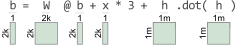

In [23]:
from IPython.display import SVG
display(SVG("/tmp/foo-2.svg"))

### Lower-level API to show abstract syntax trees (AST) and evaluate them

#### Get ast and computation result

In [24]:
root, result = tsensor.eval("W @ b + x * 3 + h.dot(h)")  # use current context to evaluate.
result

tensor([[3.3314e+08],
        [3.3455e+08],
        [3.3312e+08],
        ...,
        [3.3975e+08],
        [3.3701e+08],
        [3.2665e+08]])

#### Show the ast

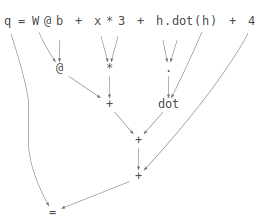

In [25]:
tsensor.astviz("q = W @ b + x * 3 + h.dot(h) + 4") # don't eval, just show AST

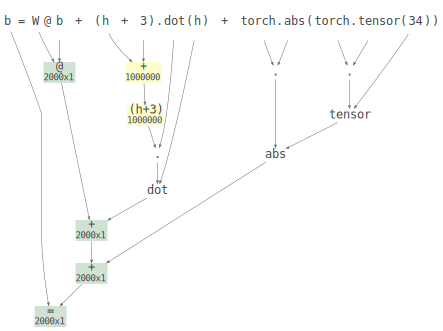

In [26]:
g = tsensor.astviz("b = W@b + (h+3).dot(h) + torch.abs(torch.tensor(34))", sys._getframe()) # eval, highlight vectors
g

#### Show specific code w/o need of a `with` statement:

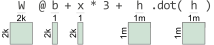

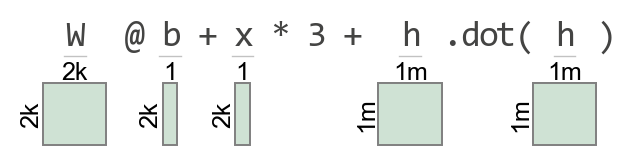

In [27]:
tsensor.pyviz("W @ b + x * 3 + h.dot(h)")